# Data Analysis

## Primeras aproximaciones de análisis

In [374]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from datetime import date

pd.set_option('display.max_columns', None)
sns.set_style("darkgrid")

# Cargamos el dataframe final de extracción, donde están todas las canciones, con duplicados (los hemos dejado
# por si utilizamos en algún momento la columna position)
data_ana = pd.read_csv("data_global.csv", sep = ',')
print(data_ana.shape)

# Quitamos las columnas que no usaremos casi seguro
data_ana= data_ana.drop(columns=['Unnamed: 0', 'Position'])
print(data_ana.shape)

# Quitamos los duplicados por canciones, no nos sirven de momento para el análisis principal.
data_ana = data_ana.drop_duplicates(subset='spotify_id').copy()
print(data_ana.shape)

#Revisamos los tipos de datos:
print(data_ana.info())

(48059, 36)
(48059, 34)
(1590, 34)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1590 entries, 0 to 48058
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Track Name         1590 non-null   object 
 1   Artist             1590 non-null   object 
 2   Streams            1590 non-null   int64  
 3   date               1590 non-null   object 
 4   spotify_id         1590 non-null   object 
 5   year               1590 non-null   int64  
 6   Streamstotal       1590 non-null   int64  
 7   album              1590 non-null   object 
 8   release_date       1590 non-null   object 
 9   length             1590 non-null   float64
 10  popularity         1590 non-null   float64
 11  acousticness       1590 non-null   float64
 12  danceability       1590 non-null   float64
 13  energy             1590 non-null   float64
 14  instrumentalness   1590 non-null   float64
 15  liveness           1590 non-null   f

/Users/victormac/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (29,30,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## PREVIO: Hacer ponderación para calcular medias respecto a los streams totales

- Añadir una columna con el peso respecto a Streams total, y respecto a su año
- Luego habría que multiplicar el valor de cada feature por el peso y sumar los resultados.

In [375]:
data_ana.head(3)

,Track Name,Artist,Streams,date,spotify_id,year,Streamstotal,album,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,artist_id,artist_followers,artist_popularity
0,Tusa,KAROL G,446086,2020-03-14,7k4t7uLgtOxPwTpFmtJNTY,2020,18848892,Tusa,2019-11-07,0.324972,0.91,0.295,0.803,0.715,0.000134,0.0574,0.911425,0.397800,0.574,0.258160,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755
61,Follow,KAROL G,152745,2020-04-02,2w1rq80FIrbxeJy9WYURxw,2020,7027186,Follow,2020-04-01,0.330442,0.78,0.667,0.735,0.787,0.000006,0.0721,0.875476,0.198031,0.455,0.711901,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755
103,Créeme,KAROL G,72543,2019-03-14,1mT47pKLXUwPYGwB91GcNz,2019,3197262,Créeme,2018-11-02,0.354546,0.72,0.154,0.715,0.872,0.000146,0.1100,0.904169,0.045599,0.682,0.230459,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755


In [376]:
# Ojo, puede ocurrir que una misma canción de un artista se repita, porque está en el top200 dos años diferentes y albunes diferentes
data_ana[data_ana['Artist'] == 'KAROL G']

,Track Name,Artist,Streams,date,spotify_id,year,Streamstotal,album,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,artist_id,artist_followers,artist_popularity
0,Tusa,KAROL G,446086,2020-03-14,7k4t7uLgtOxPwTpFmtJNTY,2020,18848892,Tusa,2019-11-07,0.324972,0.91,0.29500,0.803,0.715,0.000134,0.0574,0.911425,0.397800,0.574,0.258160,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755
61,Follow,KAROL G,152745,2020-04-02,2w1rq80FIrbxeJy9WYURxw,2020,7027186,Follow,2020-04-01,0.330442,0.78,0.66700,0.735,0.787,0.000006,0.0721,0.875476,0.198031,0.455,0.711901,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755
103,Créeme,KAROL G,72543,2019-03-14,1mT47pKLXUwPYGwB91GcNz,2019,3197262,Créeme,2018-11-02,0.354546,0.72,0.15400,0.715,0.872,0.000146,0.1100,0.904169,0.045599,0.682,0.230459,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755
153,Culpables,KAROL G,56296,2019-03-14,6q8Lb50EtqNeeJXXe8mMAH,2019,2080234,Culpables,2018-09-14,0.390787,0.69,0.27900,0.728,0.801,0.000005,0.1430,0.922521,0.065287,0.416,0.451744,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755
203,Punto G,KAROL G,51826,2019-04-05,5Lb1pjnll07UQKxNpnnGBy,2019,1930173,Punto G,2019-04-05,0.275291,0.61,0.00796,0.787,0.751,0.000139,0.0857,0.863559,0.091633,0.926,0.691617,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755
231,Punto G,KAROL G,122406,2019-05-03,2E82gORVSA7UMEz5M1IP3b,2019,1249207,OCEAN,2019-05-03,0.279327,0.62,0.00938,0.791,0.746,0.000117,0.1250,0.864281,0.097713,0.905,0.691837,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755
242,Créeme,KAROL G,64151,2019-05-03,4EKZsrsCKyqr64FBHLc0DU,2019,661661,OCEAN,2019-05-03,0.359162,0.66,0.12600,0.715,0.874,0.000162,0.1050,0.901707,0.045744,0.652,0.230833,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755
253,Love With A Quality,KAROL G,46140,2019-05-03,6F9DPkjP6Tbz9FLgLyYgX6,2019,46140,OCEAN,2019-05-03,0.383438,0.61,0.06460,0.849,0.752,0.000003,0.1060,0.895798,0.177765,0.586,0.257712,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755
254,Culpables,KAROL G,41255,2019-05-03,4RGKft6YTTWHjpQeRIInuS,2019,396519,OCEAN,2019-05-03,0.396773,0.60,0.28700,0.728,0.812,0.000003,0.1300,0.920059,0.087001,0.418,0.451544,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755
265,Ocean,KAROL G,31994,2019-05-03,6qoIFQfdmaQF9A1gb67tR7,2019,643265,OCEAN,2019-05-03,0.209542,0.74,0.93300,0.727,0.482,0.000000,0.3880,0.815791,0.132889,0.487,0.083410,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755


In [377]:
# Vemos que en el 2018 hay muchos menos Streams totales, eso puede significar que se usaba menos Spotify, o 
# que el top200 no se escuchaba tanto.
data_ana.groupby(['year']).sum()

,Streams,Streamstotal,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,artist_followers,artist_popularity
year,,,,,,,,,,,,,,,,
2017,12902458,424471115,143.359467,145.54,79.971451,264.977,270.8601,2.607547,66.2281,321.661983,38.393602,225.9088,147.358787,1543,4652707786,312.061224
2018,17597794,703032487,141.906328,156.82,93.871540,284.207,279.6534,2.373905,67.6059,343.049705,46.065576,222.2379,162.616031,1640,3666893630,327.459184
2019,23770926,932060402,132.957076,215.56,100.759445,264.008,249.0571,5.288190,63.1994,309.835259,54.750869,212.7080,154.502201,1489,3356637064,302.775510
2020,34820012,1122925513,139.772387,300.68,100.400680,298.778,282.9094,3.191402,65.4450,349.876428,58.711783,248.5395,171.267961,1659,3034180618,340.500000


In [378]:
data_ana.groupby(['year']).count()

,Track Name,Artist,Streams,date,spotify_id,Streamstotal,album,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,artist_id,artist_followers,artist_popularity
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,383,348,277,221,175,95,46,21,7,1,387,387,387
2018,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,410,370,317,211,129,56,23,8,5,1,412,412,412
2019,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,328,257,164,103,51,32,6,2,0,374,374,374
2020,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,409,330,253,104,61,24,8,2,0,0,417,417,417


In [379]:
# Vamos a añadir los pesos de cada canción en una nueva columna
# Versión optimizada corta y sin warnings

data_ana_2020 = data_ana.loc[data_ana['year'] == 2020]
data_ana_2019 = data_ana.loc[data_ana['year'] == 2019]
data_ana_2018 = data_ana.loc[data_ana['year'] == 2018]
data_ana_2017 = data_ana.loc[data_ana['year'] == 2017]

data_ana.loc[data_ana.year == 2020, 'streamstotal_weights'] = data_ana_2020['Streamstotal']/data_ana_2020['Streamstotal'].sum()
data_ana.loc[data_ana.year == 2019, 'streamstotal_weights'] = data_ana_2019['Streamstotal']/data_ana_2019['Streamstotal'].sum()
data_ana.loc[data_ana.year == 2018, 'streamstotal_weights'] = data_ana_2018['Streamstotal']/data_ana_2018['Streamstotal'].sum()
data_ana.loc[data_ana.year == 2017, 'streamstotal_weights'] = data_ana_2017['Streamstotal']/data_ana_2017['Streamstotal'].sum()



In [380]:
data_ana.head()

,Track Name,Artist,Streams,date,spotify_id,year,Streamstotal,album,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,artist_id,artist_followers,artist_popularity,streamstotal_weights
0,Tusa,KAROL G,446086,2020-03-14,7k4t7uLgtOxPwTpFmtJNTY,2020,18848892,Tusa,2019-11-07,0.324972,0.91,0.29500,0.803,0.715,0.000134,0.0574,0.911425,0.397800,0.574,0.258160,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755,0.016786
61,Follow,KAROL G,152745,2020-04-02,2w1rq80FIrbxeJy9WYURxw,2020,7027186,Follow,2020-04-01,0.330442,0.78,0.66700,0.735,0.787,0.000006,0.0721,0.875476,0.198031,0.455,0.711901,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755,0.006258
103,Créeme,KAROL G,72543,2019-03-14,1mT47pKLXUwPYGwB91GcNz,2019,3197262,Créeme,2018-11-02,0.354546,0.72,0.15400,0.715,0.872,0.000146,0.1100,0.904169,0.045599,0.682,0.230459,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755,0.003430
153,Culpables,KAROL G,56296,2019-03-14,6q8Lb50EtqNeeJXXe8mMAH,2019,2080234,Culpables,2018-09-14,0.390787,0.69,0.27900,0.728,0.801,0.000005,0.1430,0.922521,0.065287,0.416,0.451744,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755,0.002232
203,Punto G,KAROL G,51826,2019-04-05,5Lb1pjnll07UQKxNpnnGBy,2019,1930173,Punto G,2019-04-05,0.275291,0.61,0.00796,0.787,0.751,0.000139,0.0857,0.863559,0.091633,0.926,0.691617,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755,0.002071


In [381]:
'''# Forma rudimentaria de hacerlo, probar a hacerlo con un apply y lambda https://thispointer.com/pandas-apply-a-function-to-single-or-selected-columns-or-rows-in-dataframe/

data_ana_2020 = data_ana.loc[data_ana['year'] == 2020]
data_ana_2019 = data_ana.loc[data_ana['year'] == 2019]
data_ana_2018 = data_ana.loc[data_ana['year'] == 2018]

total_streams_2020 = data_ana_2020['Streamstotal'].sum()
print(total_streams_2018)
total_streams_2019 = data_ana_2019['Streamstotal'].sum()
print(total_streams_2019)
total_streams_2018 = data_ana_2018['Streamstotal'].sum()
print(total_streams_2020)

data_ana_2020['streamstotal_weights'] = data_ana_2020['Streamstotal']/total_streams_2020
data_ana_2019['streamstotal_weights'] = data_ana_2019['Streamstotal']/total_streams_2019

data_ana_2020_only = data_ana_2020[['year','spotify_id', 'streamstotal_weights']].copy()
data_ana_2019_only = data_ana_2019[['year','spotify_id', 'streamstotal_weights']].copy()
data_ana_sum = pd.concat([data_ana_2020_only, data_ana_2019_only], axis=0)

data_anam = pd.merge(data_ana, data_ana_sum, on=['year','spotify_id'])
data_anam.head()'''

"# Forma rudimentaria de hacerlo, probar a hacerlo con un apply y lambda https://thispointer.com/pandas-apply-a-function-to-single-or-selected-columns-or-rows-in-dataframe/\n\ndata_ana_2020 = data_ana.loc[data_ana['year'] == 2020]\ndata_ana_2019 = data_ana.loc[data_ana['year'] == 2019]\ndata_ana_2018 = data_ana.loc[data_ana['year'] == 2018]\n\ntotal_streams_2020 = data_ana_2020['Streamstotal'].sum()\nprint(total_streams_2018)\ntotal_streams_2019 = data_ana_2019['Streamstotal'].sum()\nprint(total_streams_2019)\ntotal_streams_2018 = data_ana_2018['Streamstotal'].sum()\nprint(total_streams_2020)\n\ndata_ana_2020['streamstotal_weights'] = data_ana_2020['Streamstotal']/total_streams_2020\ndata_ana_2019['streamstotal_weights'] = data_ana_2019['Streamstotal']/total_streams_2019\n\ndata_ana_2020_only = data_ana_2020[['year','spotify_id', 'streamstotal_weights']].copy()\ndata_ana_2019_only = data_ana_2019[['year','spotify_id', 'streamstotal_weights']].copy()\ndata_ana_sum = pd.concat([data_ana_

In [382]:
# Comprobaciones
print(data_ana.shape)

# Deberían sumar 1 los pesos de cada año
print(data_ana.loc[data_ana['year'] == 2020, 'streamstotal_weights'].sum())
print(data_ana.loc[data_ana['year'] == 2019, 'streamstotal_weights'].sum())
print(data_ana.loc[data_ana['year'] == 2018, 'streamstotal_weights'].sum())
print(data_ana.loc[data_ana['year'] == 2017, 'streamstotal_weights'].sum())

#Ver cómo sale
data_ana[data_ana['Track Name'] == 'Punto G']

(1590, 35)
1.0
1.0
1.0
1.0


,Track Name,Artist,Streams,date,spotify_id,year,Streamstotal,album,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,artist_id,artist_followers,artist_popularity,streamstotal_weights
203,Punto G,KAROL G,51826,2019-04-05,5Lb1pjnll07UQKxNpnnGBy,2019,1930173,Punto G,2019-04-05,0.275291,0.61,0.00796,0.787,0.751,0.000139,0.0857,0.863559,0.091633,0.926,0.691617,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755,0.002071
231,Punto G,KAROL G,122406,2019-05-03,2E82gORVSA7UMEz5M1IP3b,2019,1249207,OCEAN,2019-05-03,0.279327,0.62,0.00938,0.791,0.746,0.000117,0.1250,0.864281,0.097713,0.905,0.691837,4,latin,latin pop,reggaeton,reggaeton colombiano,NaN,NaN,NaN,NaN,NaN,NaN,790FomKkXshlbRYZFtlgla,11322371,0.887755,0.001340


# Análisis

In [383]:
# Vemos que el número de canciones únicas en cada año registradas
data_ana.groupby(['year']).count()

,Track Name,Artist,Streams,date,spotify_id,Streamstotal,album,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,artist_id,artist_followers,artist_popularity,streamstotal_weights
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,387,383,348,277,221,175,95,46,21,7,1,387,387,387,387
2018,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,412,410,370,317,211,129,56,23,8,5,1,412,412,412,412
2019,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,328,257,164,103,51,32,6,2,0,374,374,374,374
2020,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,409,330,253,104,61,24,8,2,0,0,417,417,417,417


## ¿Ha cambiado la cantidad de música que se escucha en spotify?

- A partir de streams totales de cada año

In [384]:
data_ana.groupby(['year']).sum()

,Streams,Streamstotal,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,artist_followers,artist_popularity,streamstotal_weights
year,,,,,,,,,,,,,,,,,
2017,12902458,424471115,143.359467,145.54,79.971451,264.977,270.8601,2.607547,66.2281,321.661983,38.393602,225.9088,147.358787,1543,4652707786,312.061224,1.0
2018,17597794,703032487,141.906328,156.82,93.871540,284.207,279.6534,2.373905,67.6059,343.049705,46.065576,222.2379,162.616031,1640,3666893630,327.459184,1.0
2019,23770926,932060402,132.957076,215.56,100.759445,264.008,249.0571,5.288190,63.1994,309.835259,54.750869,212.7080,154.502201,1489,3356637064,302.775510,1.0
2020,34820012,1122925513,139.772387,300.68,100.400680,298.778,282.9094,3.191402,65.4450,349.876428,58.711783,248.5395,171.267961,1659,3034180618,340.500000,1.0


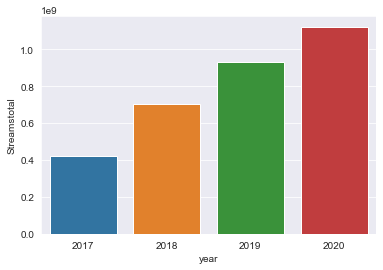

In [385]:
data_ana_streams = data_ana.loc[:, ['year', 'Streamstotal']]
data_year_streams = data_ana_streams.groupby(['year']).sum()
data_year_streams.reset_index(inplace=True)
data_year_streams

sns.barplot(x="year", y="Streamstotal", data=data_year_streams)

#### **Análisis**: Vemos que los streams total de cada año varian, siendo las del 2020 casi el doble. Cuidado porque puede ocurrir que spotify lo escuchaba menos gente, que la gente escichaba más variedad (hay que acordarse que los datos son del top200, toda la música que no esté en el top200 se queda fuera

## ¿Han cambiado las features?

### >>>Pruebas

In [386]:
# Vemos una aproximación de las medias sin ponderar de las features, a ver si tienen sentido, parece que si, y todas están entre 0 y 1
data_ana.groupby(['year']).mean()


,Streams,Streamstotal,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,time_signature,artist_followers,artist_popularity,streamstotal_weights
year,,,,,,,,,,,,,,,,,
2017,33339.684755,1.096825e+06,0.370438,0.376072,0.206645,0.684695,0.699897,0.006738,0.171132,0.831168,0.099208,0.583744,0.380772,3.987080,1.202250e+07,0.806360,0.002584
2018,42713.092233,1.706390e+06,0.344433,0.380631,0.227844,0.689823,0.678770,0.005762,0.164092,0.832645,0.111810,0.539412,0.394699,3.980583,8.900227e+06,0.794804,0.002427
2019,63558.625668,2.492140e+06,0.355500,0.576364,0.269410,0.705904,0.665928,0.014140,0.168982,0.828437,0.146393,0.568738,0.413107,3.981283,8.974965e+06,0.809560,0.002674
2020,83501.227818,2.692867e+06,0.335186,0.721055,0.240769,0.716494,0.678440,0.007653,0.156942,0.839032,0.140796,0.596018,0.410715,3.978417,7.276213e+06,0.816547,0.002398


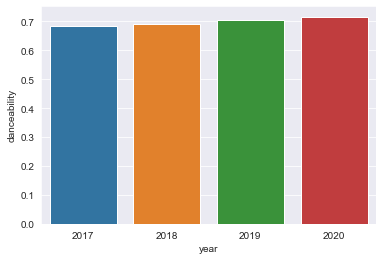

In [387]:
# Ploteamos la media de una feature concreta (sin ponderar)
data_year_means= data_ana.groupby(['year']).mean()
data_year_means.reset_index(inplace=True)
data_year_means

sns.barplot(x="year", y="danceability", data=data_year_means)

In [388]:
# Función para calcular las medias ponderadas de cada feature por años, para poner en gráficos fácilmente.
def mediapon_features (feature):
    data_dance_compar = data_ana.loc[:, ['year', feature, 'streamstotal_weights']]
    data_dance_compar["mean_pon_" + feature] = data_dance_compar[feature] * data_dance_compar['streamstotal_weights']
    media_dance_compar = data_dance_compar.groupby(['year']).sum()
    media_dance_compar.reset_index(inplace=True)
    media_dance_compar = media_dance_compar.drop(columns=[feature])
    return media_dance_compar

#Prueba
media_dance_pon = mediapon_features ('danceability')
sns.barplot(x="year", y="mean_pon_danceability", data=media_dance_pon)

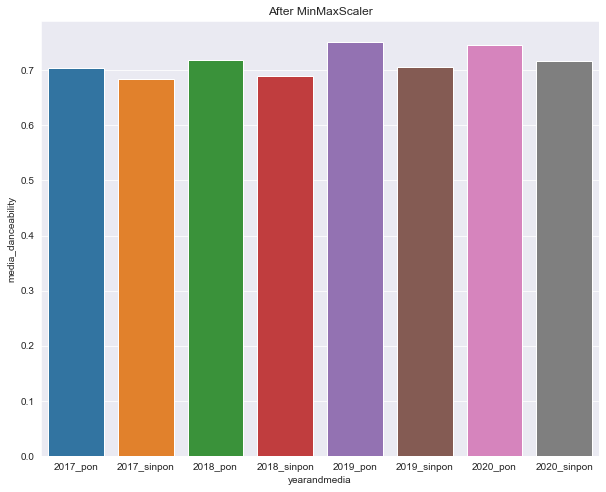

In [392]:
# Comparar medias sin y con ponderación
comparar_pon_ysinpon = pd.merge(data_year_means, media_dance_pon, how='right', on="year")
comparar_pon_ysinpon = comparar_pon_ysinpon[['year', 'danceability', 'mean_pon_danceability']]

#Hago un melt de la tabla porque quiero comparar
comparar_pon_ysinpon2 = pd.melt(comparar_pon_ysinpon,
        id_vars = ['year'],
       value_vars = ['danceability', "mean_pon_danceability"],
       value_name = 'media_danceability')

list_x = ['2017_sinpon', '2018_sinpon', '2019_sinpon', '2020_sinpon', '2017_pon', '2018_pon', '2019_pon', '2020_pon']
comparar_pon_ysinpon2['yearandmedia'] = list_x
comparar_pon_ysinpon2 =  comparar_pon_ysinpon2.drop(columns=['variable', 'year'])
comparar_pon_ysinpon2 = comparar_pon_ysinpon2.sort_values('yearandmedia')

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('After MinMaxScaler')
sns.barplot(x="yearandmedia", y ='media_danceability', data=comparar_pon_ysinpon2)

# Hay una diferencia, se ve que en general aumentan los valores.

In [394]:
data_ana.columns

Index(['Track Name', 'Artist', 'Streams', 'date', 'spotify_id', 'year',
       'Streamstotal', 'album', 'release_date', 'length', 'popularity',
       'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'valence', 'tempo',
       'time_signature', 'genre1', 'genre2', 'genre3', 'genre4', 'genre5',
       'genre6', 'genre7', 'genre8', 'genre9', 'genre10', 'artist_id',
       'artist_followers', 'artist_popularity', 'streamstotal_weights'],
      dtype='object')

### >>> length

**Features:**
'length'
'popularity'
'acousticness'
'danceability'
'energy'
'instrumentalness'
'liveness'
'loudness'
'speechiness'
'valence'
'tempo'

,year,streamstotal_weights,mean_pon_length
0,2017,1.0,0.376400
1,2018,1.0,0.356756
2,2019,1.0,0.373912
3,2020,1.0,0.335106


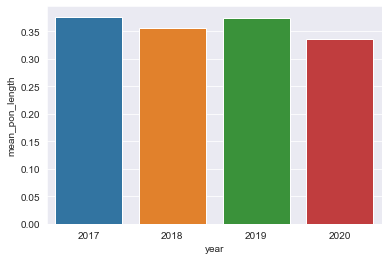

In [331]:
media_length = mediapon_features ('length')
sns.barplot(x="year", y="mean_pon_length", data=media_length)
media_length

### >>> Popularity

,year,streamstotal_weights,mean_pon_popularity
0,2017,1.0,0.369609
1,2018,1.0,0.367623
2,2019,1.0,0.588037
3,2020,1.0,0.771828


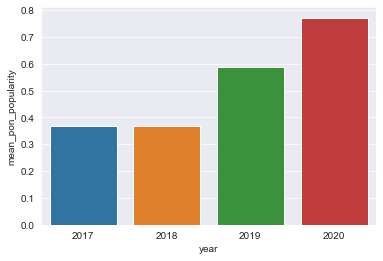

In [333]:
media_popularity = mediapon_features ('popularity')
sns.barplot(x="year", y="mean_pon_popularity", data=media_popularity)
media_popularity

### >>> acousticness

,year,streamstotal_weights,mean_pon_acousticness
0,2017,1.0,0.173837
1,2018,1.0,0.198447
2,2019,1.0,0.276493
3,2020,1.0,0.218525


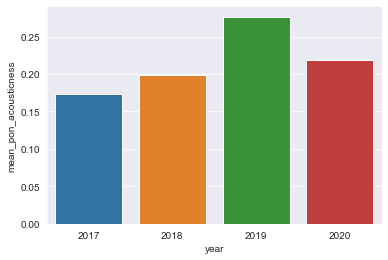

In [334]:
media_acousticness = mediapon_features ('acousticness')
sns.barplot(x="year", y="mean_pon_acousticness", data=media_acousticness)
media_acousticness

### >>> danceability

,year,streamstotal_weights,mean_pon_danceability
0,2017,1.0,0.704916
1,2018,1.0,0.718892
2,2019,1.0,0.752050
3,2020,1.0,0.745392


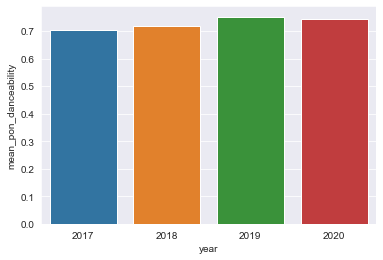

In [335]:
media_danceability = mediapon_features ('danceability')
sns.barplot(x="year", y="mean_pon_danceability", data=media_danceability)
media_danceability

### >>> energy

,year,streamstotal_weights,mean_pon_energy
0,2017,1.0,0.748913
1,2018,1.0,0.719493
2,2019,1.0,0.685468
3,2020,1.0,0.703327


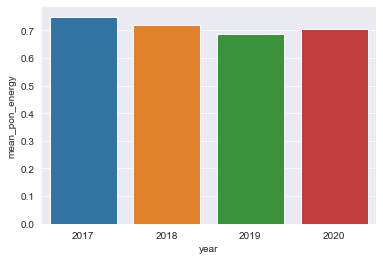

In [336]:
media_energy = mediapon_features ('energy')
sns.barplot(x="year", y="mean_pon_energy", data=media_energy)
media_energy

### >>> instrumentalness

,year,streamstotal_weights,mean_pon_instrumentalness
0,2017,1.0,0.001845
1,2018,1.0,0.001609
2,2019,1.0,0.002610
3,2020,1.0,0.007286


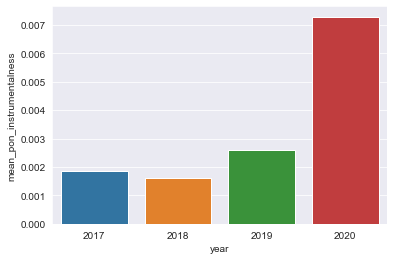

In [337]:
# Se ve un aumento, pero no es significativo, de 0,5 a 0 se considera no instrumental
media_instrumentalness = mediapon_features ('instrumentalness')
sns.barplot(x="year", y="mean_pon_instrumentalness", data=media_instrumentalness)
media_instrumentalness

### >>> liveness

,year,streamstotal_weights,mean_pon_liveness
0,2017,1.0,0.159971
1,2018,1.0,0.189007
2,2019,1.0,0.155698
3,2020,1.0,0.149722


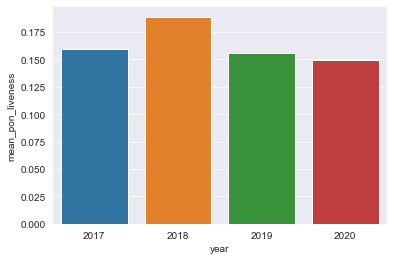

In [339]:
media_liveness = mediapon_features ('liveness')
sns.barplot(x="year", y="mean_pon_liveness", data=media_liveness)
media_liveness

### >>> loudness

,year,streamstotal_weights,mean_pon_loudness
0,2017,1.0,0.857414
1,2018,1.0,0.852523
2,2019,1.0,0.850310
3,2020,1.0,0.855269


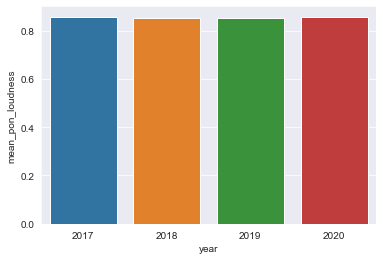

In [340]:
media_loudness = mediapon_features ('loudness')
sns.barplot(x="year", y="mean_pon_loudness", data=media_loudness)
media_loudness

### >>> speechiness

,year,streamstotal_weights,mean_pon_speechiness
0,2017,1.0,0.111891
1,2018,1.0,0.098769
2,2019,1.0,0.147694
3,2020,1.0,0.136579


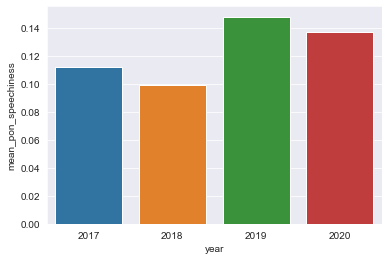

In [345]:
media_speechiness = mediapon_features ('speechiness')
sns.barplot(x="year", y="mean_pon_speechiness", data=media_speechiness)
media_speechiness

### >>> valence

,year,streamstotal_weights,mean_pon_valence
0,2017,1.0,0.628673
1,2018,1.0,0.609709
2,2019,1.0,0.612495
3,2020,1.0,0.638240


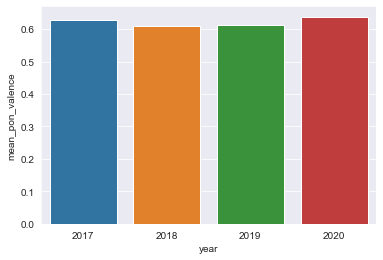

In [343]:
media_valence = mediapon_features ('valence')
sns.barplot(x="year", y="mean_pon_valence", data=media_valence)
media_valence

### >>> tempo

,year,streamstotal_weights,mean_pon_tempo
0,2017,1.0,0.352080
1,2018,1.0,0.392161
2,2019,1.0,0.382988
3,2020,1.0,0.399164


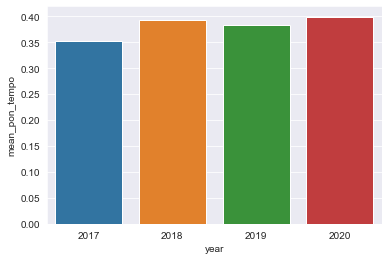

In [344]:
media_tempo = mediapon_features ('tempo')
sns.barplot(x="year", y="mean_pon_tempo", data=media_tempo)
media_tempo

### ¿Hay correlación entre la popularidad del artista y los streams?

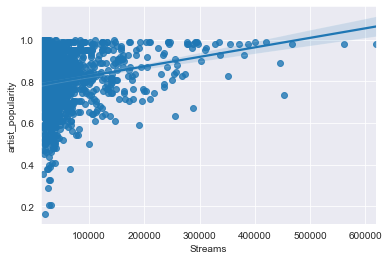

In [395]:
# Correlaciones
#sns.relplot(x="artist_popularity", y="Streamstotal", data=data_ana)
sns.regplot(x="Streams", y="artist_popularity", data=data_ana);

### ¿Hay correlación entre la popularidad de la canción y los streams?

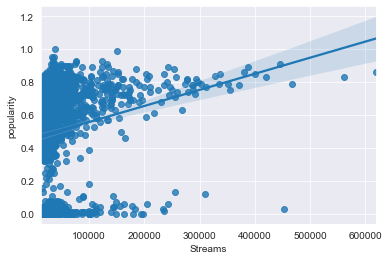

In [397]:
sns.regplot(x="Streams", y="popularity", data=data_ana);